# Lavaux Sensor Data: Relative Humidity 

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import re
from scipy import stats
import sklearn

from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from tslearn.clustering import TimeSeriesKMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

# 0. Import Temperature of all files 
readout from HOBO sensors on these dates:
1. 2022-03-08
2. 2023-05-10
3. 2023-09-20

--> First column is temperature, second one RH

In [3]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data')

In [4]:
md = pd.read_csv('sensors_metadata.tsv', sep='\t', index_col=0)

# make dict to rename the sensor names with the plot ID 
rename_columns_dict = dict(zip(md["Sensors"], md.index))

### 1. 2021-2022

> note Lavaux_003 measured all 15 min (consider subsampling with `df['Lavaux_003'].resample('1H').mean()`)

> Sensors were installed on 2021-04-20 and read out 2022-03-08 

In [6]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2021')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,3], index_col=0) for f in all_files]
df_2022 = pd.concat(dfs, axis=1)
df_2022.index = pd.to_datetime(df_2022.index)

# sort by timestamp 
df_2022.sort_index(inplace=True)

# name columns 
df_2022.set_axis(names, axis=1, inplace=True)
df_2022.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2022 = df_2022[(df_2022.index > '2021-04-21 00:30:00') & (df_2022.index < '2022-03-08 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_16782/1029445485.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2022.set_axis(names, axis=1, inplace=True)


### 2. 2022-2023 
> note two sensors have gone missing when reading out the sensors in 2023!

In [7]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_1')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,3], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023.set_axis(names, axis=1, inplace=True)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_1 = df_2023[(df_2023.index > '2022-03-08 18:00:00') & (df_2023.index < '2023-05-10 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_16782/873249630.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2023.set_axis(names, axis=1, inplace=True)


### 3. 2023 
growing season of 2023, sensors were collected at harvest (2023-09-20)

In [8]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_2')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,3], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023.set_axis(names, axis=1, inplace=True)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_2 = df_2023[(df_2023.index > '2023-05-10 09:00:00') & (df_2023.index < '2023-09-20 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_16782/949315270.py:17: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_2023.set_axis(names, axis=1, inplace=True)


### Merge all data

In [9]:
df_RH = pd.concat([df_2022,df_2023_1,df_2023_2], join='outer', axis=0)
#df_RH.tail()

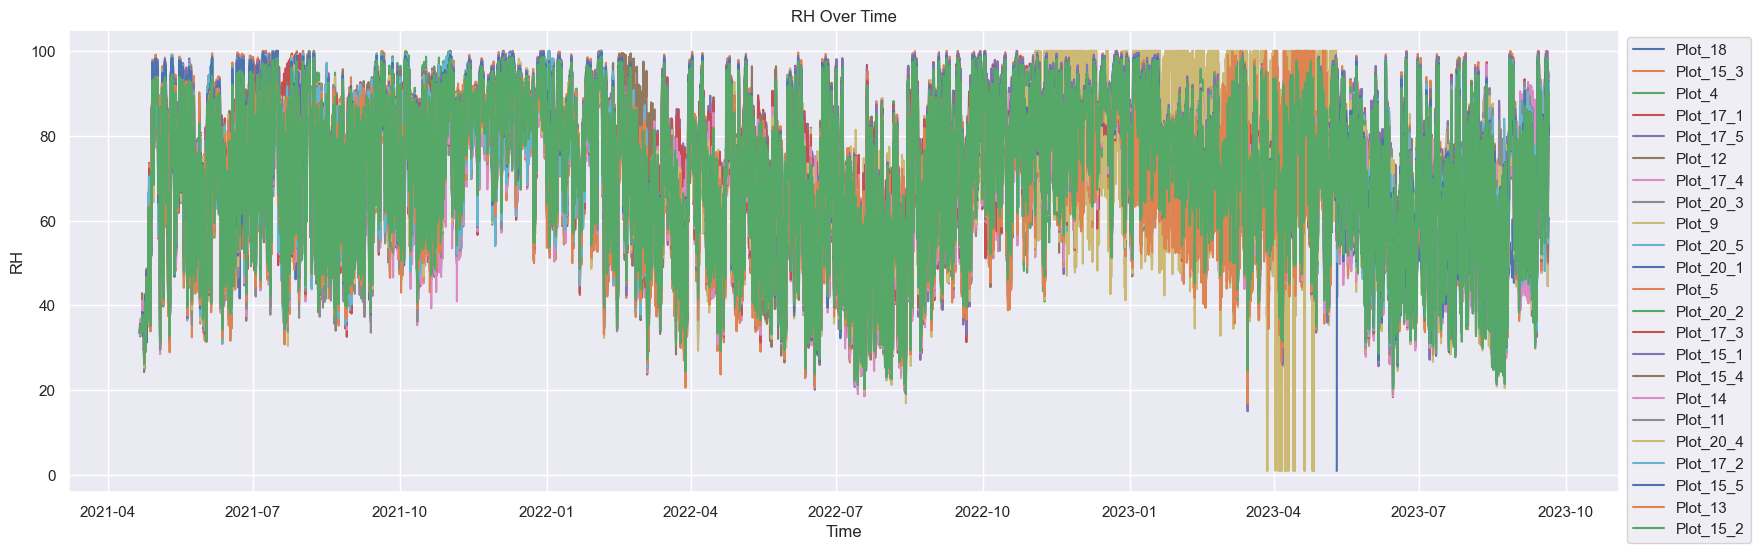

In [10]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))

# get mean temperature for each month
show_temps = df_RH.resample('H').mean()

# loop over columns and plot temperatures 
for column in show_temps.columns:
    plt.plot(show_temps.index, show_temps[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('RH')
plt.title('RH Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.show()

# 1. Outlier correction with MAD 
see Temperature script for more tests and info

In [11]:
MAD_threshold = 3.5

MAD_window = 24
MAD_neighbors = 5

In [12]:
# function to compare each value to other values at this timestamp and to remove values outside of the specified threshold 

def remove_outliers(row, num_neighbors = MAD_neighbors, threshold = MAD_threshold):
    # Find non-NaN values in the row
    non_na_indices = row.dropna().index
    
    # If there are fewer than num_neighbors non-NaN values, return the original row
    if len(non_na_indices) < num_neighbors:
        return row
    
    # Extract values for comparison
    values_to_compare = row[non_na_indices].values
    
    # Calculate the median and median absolute deviation (MAD)
    median_value = np.median(values_to_compare)
    mad = np.median(np.abs(values_to_compare - median_value))
    
    # Identify indices of outliers based on the MAD and threshold
    outlier_indices = non_na_indices[np.abs(values_to_compare - median_value) > threshold * mad]
    
    # Replace outliers with NaN
    row[outlier_indices] = pd.NA
    
    return row

In [13]:
# Remove outliers using rolling Median Absolute Deviation (MAD) for each column.

def remove_outliers_rolling(df, window_size = MAD_window, threshold = MAD_threshold):

    result_df = df.copy()

    for column in df.columns:
        column_data = df[column]

        # Use rolling median and rolling MAD
        rolling_median = column_data.rolling(window=window_size, min_periods=1, center=True).median()
        rolling_mad = column_data.rolling(window=window_size, min_periods=1, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))))

        # Identify outliers
        outliers = np.abs(column_data - rolling_median) > threshold * rolling_mad

        # Mark outliers in the result DataFrame with NaN
        result_df.loc[outliers, column] = pd.NA

    return result_df

In [14]:
# let's resample per hour 
df = df_RH.resample('H').mean()

# Apply the remove_outliers function to each column in the DataFrame
df_outliers_MAD = df.apply(remove_outliers, axis=1)

In [15]:
# Set window size and apply the function
df_outliers_rollingMAD = remove_outliers_rolling(df)

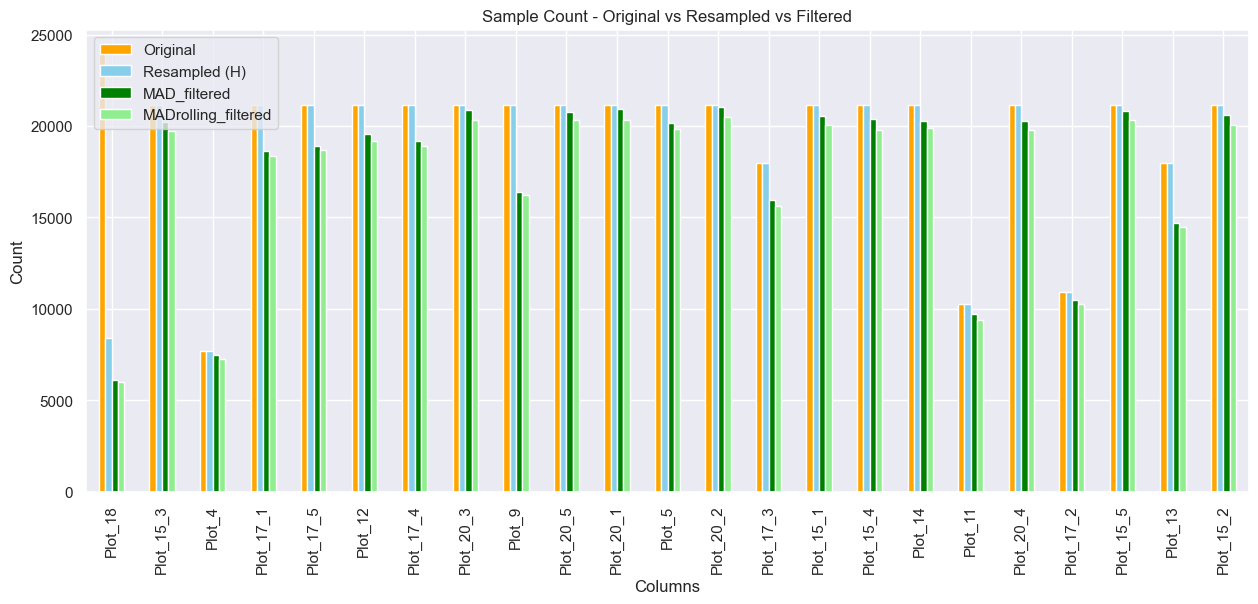

In [16]:
## quickly show how many entries we "loose" from resampling 

original_counts = df_RH.count()
resampled_counts = df_RH.resample('H').mean().count()
MAD_counts = df_outliers_MAD.count()
MADrolling_counts = df_outliers_rollingMAD.count()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'Original': original_counts, 'Resampled (H)': resampled_counts, 'MAD_filtered' : MAD_counts, 'MADrolling_filtered' : MADrolling_counts})

# Plot the grouped bar chart
ax = plot_data.plot(kind='bar', figsize=(15, 6), color=['orange','skyblue','green', 'lightgreen'])

# Set plot labels and title
ax.set_ylabel('Count')
ax.set_xlabel('Columns')
ax.set_title('Sample Count - Original vs Resampled vs Filtered')

# Display legend
ax.legend()

# Show the plot
plt.show()


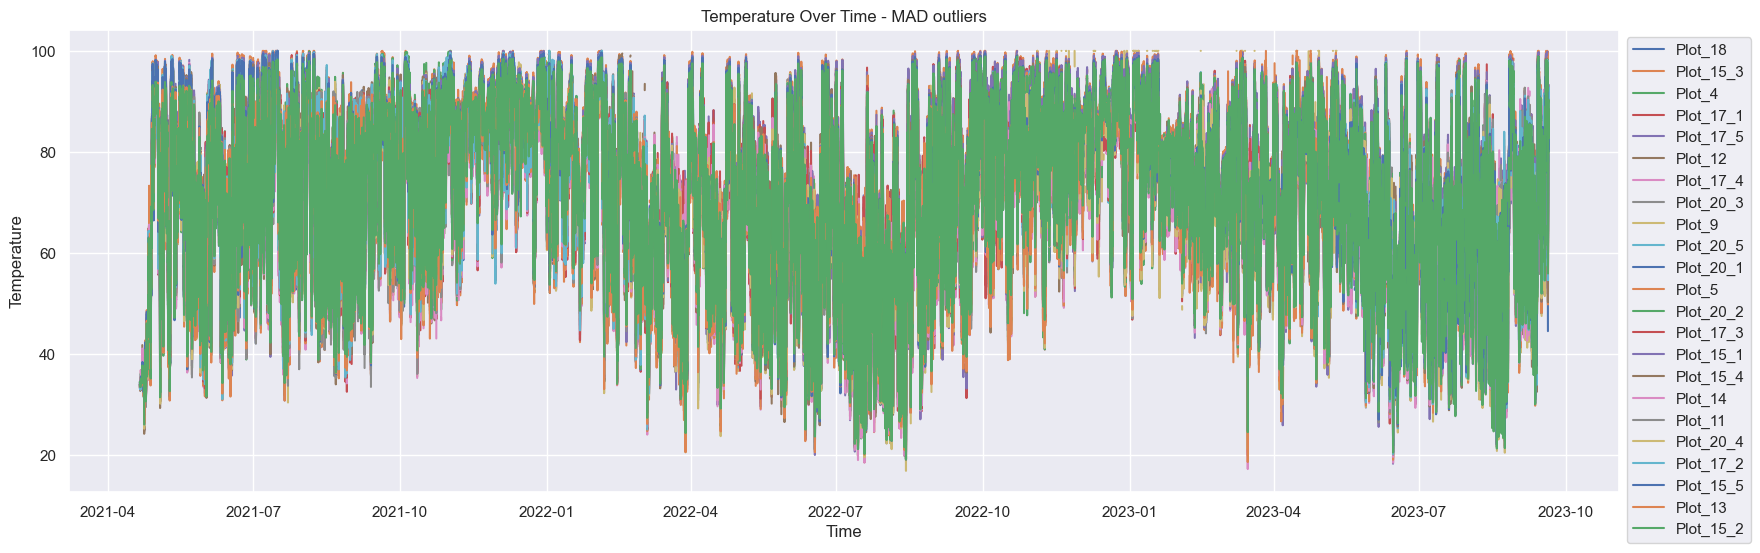

In [17]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_MAD.columns:
    plt.plot(df_outliers_MAD.index, df_outliers_MAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD outliers')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

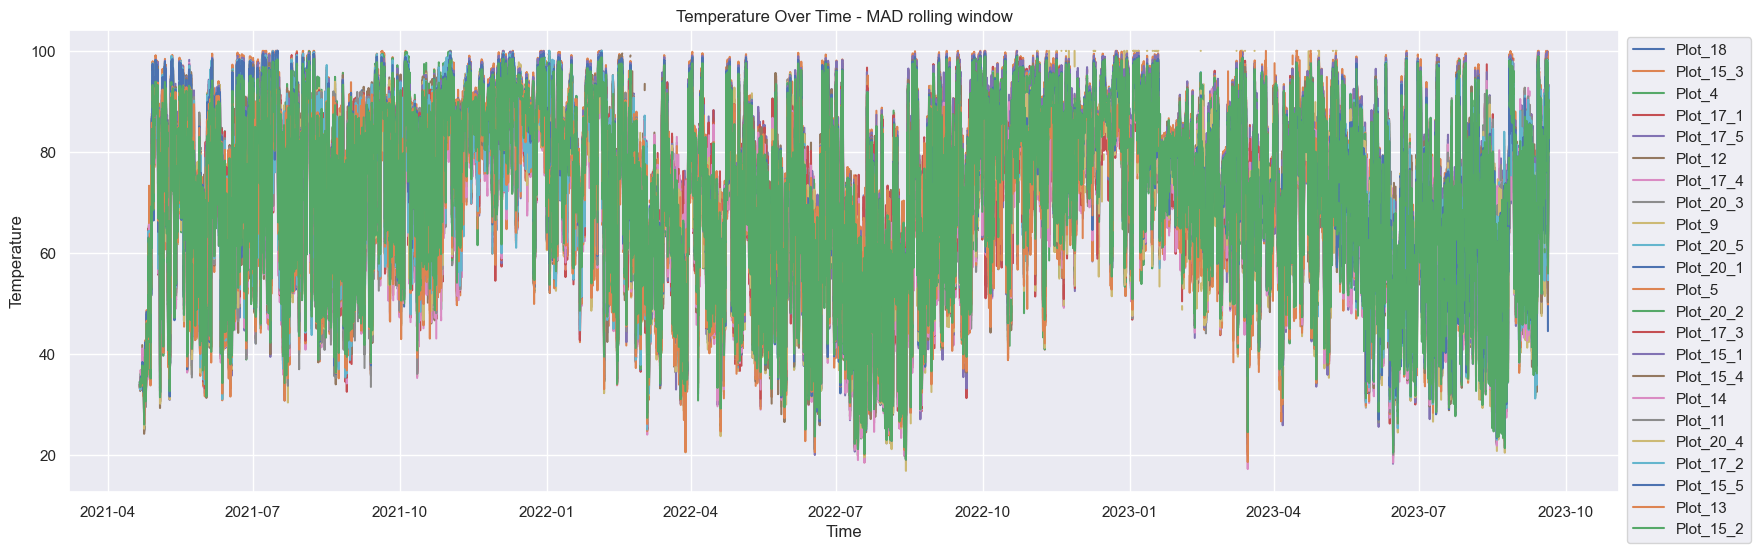

In [26]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_rollingMAD.columns:
    plt.plot(df_outliers_rollingMAD.index, df_outliers_rollingMAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD rolling window')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

# 2. Comparing the years 

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_16782/1049619901.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")


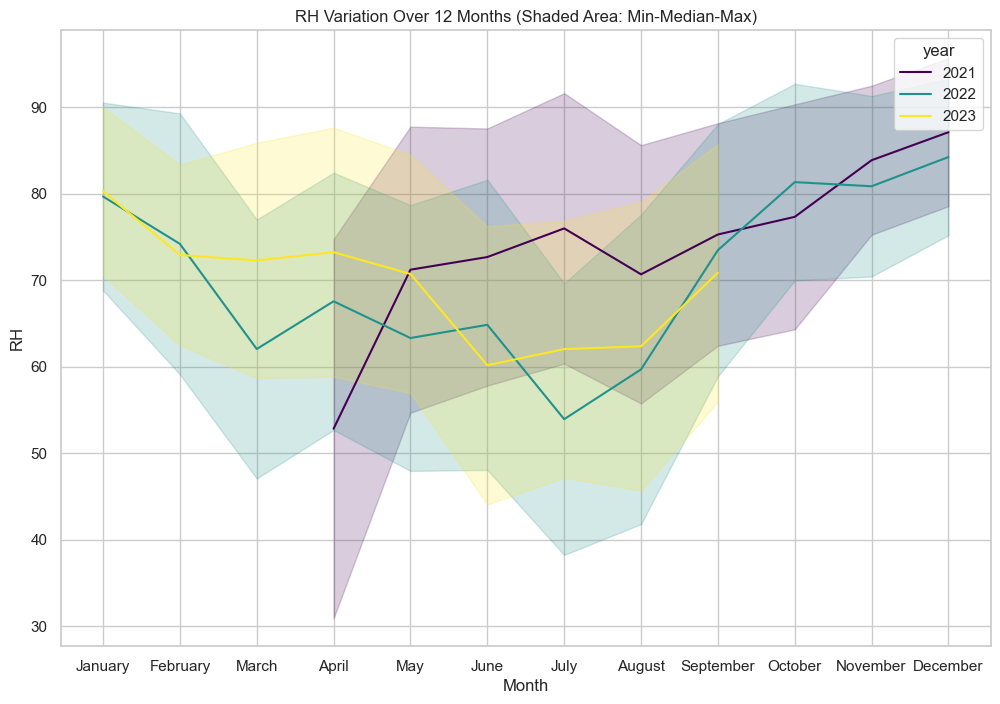

In [18]:
df = df_outliers_MAD.copy()

# Extract year and month from the timestamp
df['year'] = df.index.year
df['month'] = df.index.month
df_melted = pd.melt(df, id_vars=['year', 'month'], var_name='temperature_type', value_name='temperature')

# Create a line plot with shaded area using seaborn
plt.figure(figsize=(12, 8))

sns.set_style("whitegrid")

sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")
plt.title('RH Variation Over 12 Months (Shaded Area: Min-Median-Max)')
plt.xlabel('Month')
plt.ylabel('RH')

# Customize x-axis ticks for every month
plt.xticks(range(1, 13), [pd.to_datetime(str(i), format='%m').strftime('%B') for i in range(1, 13)])

plt.show()

# 3. Interplot variance

### Statistical testing 

> mean temperatures of months / weeks **are not** statistically significant between each other 

In [19]:
df = df_outliers_MAD

In [20]:
# Perform Kruskal-Wallis test on each row
p_values = []
for _, row in df.iterrows():
    _, p_value = stats.kruskal(*row.values)
    p_values.append(p_value)

# Create a new DataFrame with p-values
p_value_df = pd.DataFrame({'P-Value': p_values}, index=df.index)

# Filter and print rows with significant p-values
significant_rows = p_value_df[p_value_df['P-Value'] < 0.05]
print(significant_rows)

Empty DataFrame
Columns: [P-Value]
Index: []


### Add some metadata

In [21]:
# Merge the dataframes based on the sensor name (reset the index first) and sort: first by altitude and then by plot 
ave_RH_new = df_outliers_MAD.reset_index() 
md_renamed = md.reset_index()
merged_df = ave_RH_new.melt(id_vars='index', var_name='ID', value_name='RH').merge(md, on='ID').sort_values(by = ['Altitude', 'ID'])

### Boxplots

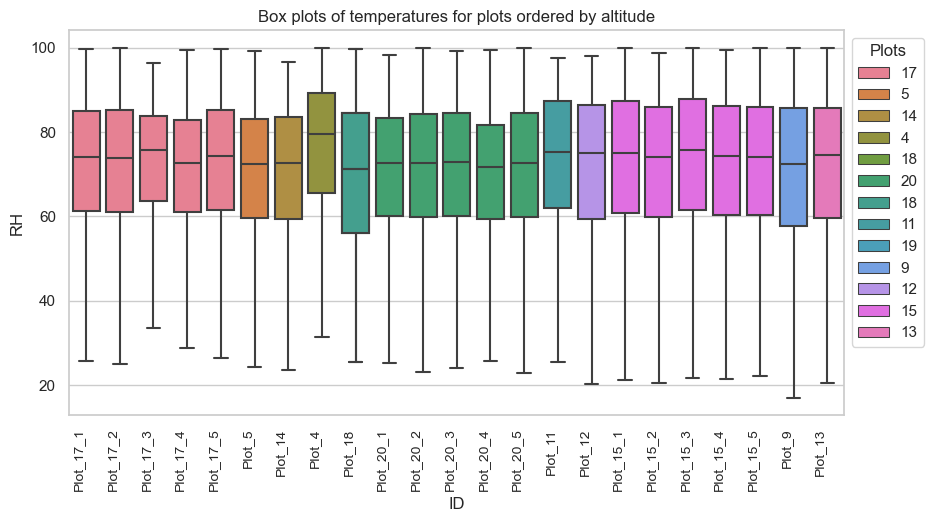

In [22]:
plt.figure(figsize=(10,5))

plots_ordered_by_altitude = [17, 5, 14, 4, 18, 20, 18, 11, 19, 9, 12, 15, 13]

ax = sns.boxplot(x='ID', y='RH', hue="Plots", 
                 width=0.8, dodge=False,
                 data=merged_df, palette="husl", 
                 hue_order=plots_ordered_by_altitude,
                 showfliers = False
                 )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Box plots of temperatures for plots ordered by altitude')

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
)
None
# the None is to not show the lables as output 

### Heatmaps

In [23]:
df = df_outliers_MAD.copy()

# Extract unique plot names
plot_names = set('_'.join(col.split('_')[:2]) for col in df.columns)
plot_names

# Calculate median for each group of columns with the same plot name
median_values = {}
for plot_name in plot_names:
    columns = [col for col in df.columns if plot_name in col]
    median_values[plot_name] = df[columns].median(axis=1)

# Concatenate median values into a new DataFrame
df_median = pd.DataFrame(median_values)

df_median

,Plot_20,Plot_18,Plot_15,Plot_13,Plot_14,Plot_4,Plot_17,Plot_5,Plot_9,Plot_11,Plot_12
2021-04-21 00:00:00,NaN,34.11200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 01:00:00,34.0770,33.98650,34.0690,33.856,34.441,34.966,33.8180,33.781,34.576,33.841,33.422
2021-04-21 02:00:00,33.8285,33.83350,33.9455,33.814,34.073,NaN,33.7120,33.577,34.437,33.768,33.321
2021-04-21 03:00:00,33.6385,33.66200,33.8250,33.772,33.834,NaN,33.6330,33.372,34.300,33.695,33.183
2021-04-21 04:00:00,33.4710,33.51675,33.7010,33.730,33.628,34.481,33.4960,33.235,34.161,33.620,33.048
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20 03:00:00,83.2990,NaN,85.2030,NaN,NaN,NaN,84.4910,83.741,82.553,79.940,85.675
2023-09-20 04:00:00,84.6450,NaN,84.6720,NaN,NaN,NaN,87.5075,84.134,85.901,82.026,85.963
2023-09-20 05:00:00,89.4830,NaN,88.1370,NaN,94.969,NaN,89.9480,86.491,86.684,84.162,85.657
2023-09-20 06:00:00,89.0380,NaN,90.0235,NaN,NaN,NaN,90.2470,86.154,90.882,89.459,NaN


In [24]:
# Create heatmap
df_heatmap = df_median.T

# Get month names
monthly = df_median.resample('M').mean()
month_names = monthly.index.strftime('%B, %Y')

# Heatmap 
plt.figure(figsize=(20, 5), dpi=1000)
heatmap = sns.heatmap(data=df_heatmap, cmap='BrBG', annot=None, 
                      cbar_kws={'label': 'Relative Humidity [%]', 'shrink': 0.7, 'aspect': 15, 'pad': 0.02})
#plt.title('Heatmap of all plots over the years')

# Set custom x-axis labels
n = len(month_names)
heatmap.set_xticks(np.linspace(0, n - 1, n))
heatmap.set_xticklabels(month_names)

# Calculate positions for the labels
width = heatmap.get_xlim()[1] - heatmap.get_xlim()[0]
positions = np.linspace(heatmap.get_xlim()[0], heatmap.get_xlim()[1], len(month_names))

# Set label positions
plt.xticks(positions, month_names)

plt.tight_layout()
plt.show()